In this approach we will take the following steps:
1. Split customers into `train` and `validation` as 80%/20%
2. Scale data (fit_transform on `train` and only transform on `validation`)
3. Fit KMeans clusters with `train`, predict for `train`, add to `train` as a new feature predicted cluster
4. Predict for `validation`, add to `validation` as a new feature predicted cluster
5. Fit Support Vector Machine (Classifier) with `train` and predict for `validation`
6. Check results with classification report on predictions for `validation`

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC

%matplotlib inline
np.random.seed(59)

# set the max columns to none
pd.set_option('display.max_columns', None)

In [11]:
train_path = 'D:\\machine learning\\ml projects\\Main Pet Project for May-June 2022\\Customer Churn Prediction\\preprocessed_data\\train.csv'

df = pd.read_csv(train_path)
df.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,state_MD,state_MN,state_NJ,state_TX,state_WV,state_other
0,107,0,1,26,13.7,3,3.70,1,0,611.5,329,55.54,0,1,0,0,0,0,0,0,1
1,137,0,0,0,12.2,5,3.29,0,0,527.2,328,59.00,0,1,0,0,0,1,0,0,0
2,84,1,0,0,6.6,7,1.78,2,0,558.2,248,65.02,1,0,0,0,0,0,0,0,1
3,75,1,0,0,10.1,3,2.73,3,0,501.9,356,49.36,0,1,0,0,0,0,0,0,1
4,121,0,1,24,7.5,7,2.03,3,0,779.3,314,76.28,0,0,1,0,0,0,0,0,1


Split the data to train and validation (without test)

In [12]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=59)

It is important to scale the data

In [13]:
st_scaler = StandardScaler()

X_train_st = st_scaler.fit_transform(X_train)
X_val_st = st_scaler.transform(X_val)

Check the elbow, to determine what is the optimal number of clusters

In [14]:
km_list = list()

for i in range(1, 30):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=59)
    km = km.fit(X_train_st)
    
    km_list.append(pd.Series({'clusters': i, 
                              'inertia': km.inertia_,
                              'model': km}))

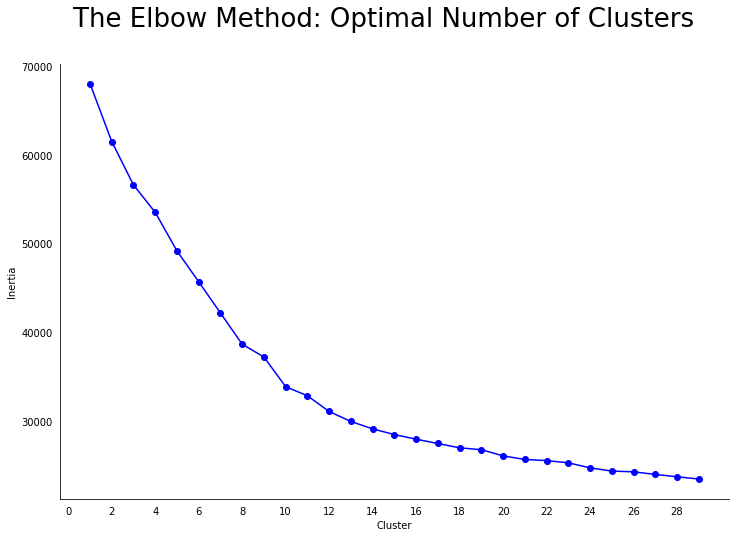

In [15]:
k = pd.concat(km_list, axis=1).T[['clusters','inertia']]

# Visualize
fig, ax = plt.subplots(figsize =(12, 8))
fig.patch.set_facecolor('white')

plt.plot(k['clusters'], k['inertia'], 'bo-')

# Remove ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Remove axes splines
for i in ['top','right']:
    ax.spines[i].set_visible(False)

ax.set_xticks(range(0, 30, 2))
ax.set(xlabel='Cluster', ylabel='Inertia')

plt.suptitle('The Elbow Method: Optimal Number of Clusters', size=26)
plt.show()

12 clusters is enough

In [26]:
kmeans = KMeans(n_clusters=12, max_iter=300, n_init=10, random_state=59)
kmeans.fit(X_train_st)

predicted_clusters_train = kmeans.predict(X_train_st)
X_train_st = np.column_stack((X_train_st, predicted_clusters_train))

predicted_clusters_val = kmeans.predict(X_val_st)
X_val_st = np.column_stack((X_val_st, predicted_clusters_val))

In [27]:
svm = SVC()
svm.fit(X_train_st, y_train)
y_pred = svm.predict(X_val_st)

In [29]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_val, y_pred))
print('F1 Score', f1_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       732
           1       0.86      0.31      0.46       118

    accuracy                           0.90       850
   macro avg       0.88      0.65      0.70       850
weighted avg       0.89      0.90      0.88       850

F1 Score 0.45962732919254656


F1 Score = 0.46

To sum up: the biggest failure is in churn prediction (who would think), so it is important to somehow remove class imbalance (Oversample or Undesample)